In [309]:
import os
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

In [200]:
data_dir = "./data/"
out_dir = './output/'

数据集一共三个文件：
- `candidate_items_A.csv`: 候选视频表；
- `main_vv_seq_train.csv`: 用户观看视频行为表；
- `vid_info.csv`: 视频信息表；

各个字段的介绍：[https://challenge.ai.mgtv.com/contest/detail/16](https://challenge.ai.mgtv.com/contest/detail/16).
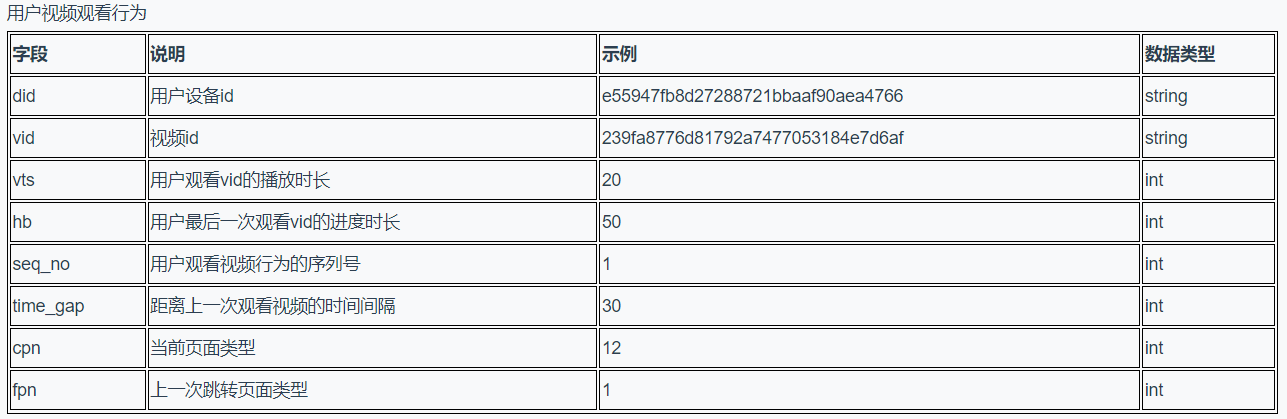
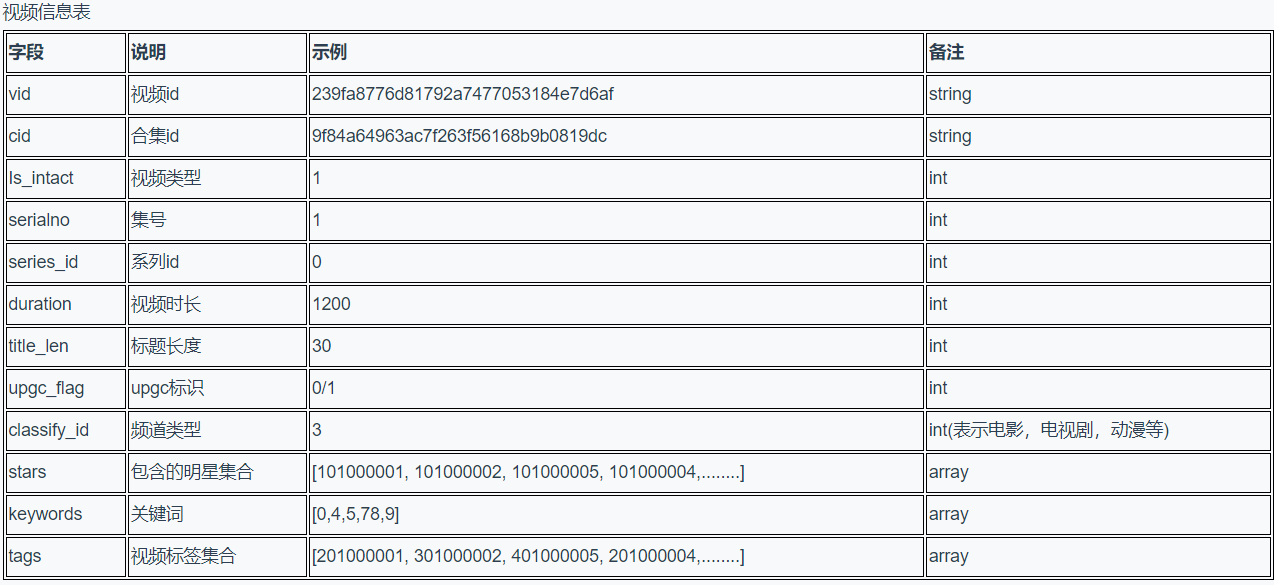

# 用户观看视频行为

- id 类特征：did, vid；
- 类别特征：cpn, fpn, upgc；
- 序号：seq_no. 该特征标识了一个用户观看视频的顺序；
- 连续特征：都是关于时间的，vts, hb, time_gap；

In [354]:
main = pd.read_csv(data_dir + 'main_vv_seq_train.csv')
main

,did,vid,vts,hb,seq_no,cpn,fpn,time_gap
0,5ebf5b53f2fdec1eadba29c3b2155e8e,83cf1332aa7315c755cc8bdd356513af,111.0,84.0,5.0,1,130,87.0
1,5ebf5b53f2fdec1eadba29c3b2155e8e,18d443cacff1173b21ea4c28c8bdf3b0,114.0,85.0,4.0,1,130,115.0
2,5ebf5b53f2fdec1eadba29c3b2155e8e,27d332d1ad1a58e205b797be64d30e13,137.0,80.0,3.0,1,130,75.0
3,5ebf5b53f2fdec1eadba29c3b2155e8e,2ac8e7855bb39cd1dace86c7cd5e72b7,91.0,74.0,2.0,1,130,90.0
4,5ebf5b53f2fdec1eadba29c3b2155e8e,941e1b0a4e8d5ae20ab328f21e8bfcc0,118.0,86.0,1.0,1,130,NaN
...,...,...,...,...,...,...,...,...
5596408,b682795ff4e48bf15141fdebbd734b5c,85c018c2d03fc198abde5757d7490e6f,27.0,2456.0,5.0,1,130,33.0
5596409,b682795ff4e48bf15141fdebbd734b5c,eeb515f1d5113f93176093d683e0ea6e,52.0,2351.0,4.0,1,130,42.0
5596410,b682795ff4e48bf15141fdebbd734b5c,f5ad5ce447be056feafeca2f3bb3b0a7,51.0,2064.0,3.0,1,130,5.0
5596411,b682795ff4e48bf15141fdebbd734b5c,a41ddcc1f1d279ea2e1eff2c3459f7b7,186.0,2033.0,2.0,1,68,160376.0


In [296]:
main.did.nunique()

170909

In [30]:
main.vid.nunique()

147074

In [298]:
main.cpn.nunique()

33

最短的行为序列长度=4	最长的行为序列长度=494	平均行为序列长度= 32.745


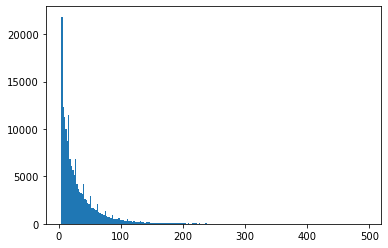

In [320]:
cnt = Counter(main['did_'])
tmp = cnt.values()

print(f"最短的行为序列长度={min(tmp)}\t最长的行为序列长度={max(tmp)}\t平均行为序列长度={sum(tmp) / len(tmp) : .3f}")

_ = plt.hist(tmp, bins=len(set(tmp))//2, log=0)

In [370]:
print(sorted(main.fpn.unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139]


## 缺失值情况

In [377]:
for c in main:
    print('%s: %d' %(c, main[c].isna().sum()))

did: 0
vid: 0
vts: 0
hb: 0
seq_no: 0
cpn: 0
fpn: 0
time_gap: 170909
did_: 0
vid_: 0


In [366]:
cat_feats = ['cpn', 'fpn']
for c in cat_feats:
    print('%s: %d %d %d' %(c, main[c].nunique(), main[c].min(), main[c].max()))

cpn: 33 0 32
fpn: 139 0 139


# 视频信息
- id 类特征：vid, cid, series_id
- 类别特征：is_intact, upgc_flag, classifiy_id, 
- 集合类特征：stars, keywords, tags
- 连续特征：duration, title_len
- 序号：serialno，集号，每个视频都有一个集合, 每一集就是一个视频.

有几个关系需要搞清楚：
- serialno 于 cid, series_id 的关系是啥？按照分组的情况来看，serialno 与 series_id 的关系不是很大，serialno 应该是针对同一个 cid 而言的，即一个 cid 内的视频的 serialno 是有顺序关系的。但是一个 cid 内的视频，其 serialno 好像并不是完整的，存在一些这样的情况：
    - vid 不同，但是 serialno 相同；
    - serialno 并不是连续的；
    - serialno 之间基本存在顺序关系；

In [355]:
vinfo = pd.read_csv(data_dir + 'vid_info.csv')
vinfo.head(2)

,vid,cid,is_intact,serialno,classify_id,series_id,duration,title_length,upgc_flag,stars,tags,key_word
0,031185e8b99d2240b4a7201196881a7c,6472f5d9715933b07cf74a8b5868447a,4,0,1,0,99,65,0,"[101000001, 101006658, 101028796]","[101000002, 101000004, 101000005, 101000006, 1...","['386650', '726773', '574504', '401841', '7711..."
1,6dde147901c36a003c525bbe477b73be,6472f5d9715933b07cf74a8b5868447a,3,0,1,0,120,91,0,"[101001415, 101002401]","[101000001, 101000002, 101000004, 101000005, 1...","['333465', '401841', '726773', '574504', '7711..."


In [286]:
vinfo.shape

(149626, 14)

## 缺失值情况

In [300]:
vinfo.cid.nunique(), vinfo.series_id.nunique()

(7394, 1118)

In [378]:
for c in vinfo:
    print('%s: %d' %(c, vinfo[c].isna().sum()))

vid: 0
cid: 0
is_intact: 0
serialno: 0
classify_id: 0
series_id: 0
duration: 0
title_length: 0
upgc_flag: 0
stars: 0
tags: 0
key_word: 0
vid_: 0
cid_: 0
is_intact_: 0
classify_id_: 0


## 类别分布

In [322]:
cat_feats = ['cid', 'is_intact', 'serialno', 'series_id', 'upgc_flag', 'classify_id']
for c in cat_feats:
    print('%s: %d' % (c, vinfo[c].nunique()))
    if vinfo[c].nunique() < 20:
        print(vinfo[c].unique())

cid: 7394
is_intact: 9
[ 4  3  2  1  7  5  8  9 10]
serialno: 4492
series_id: 1118
upgc_flag: 2
[0 1]
classify_id: 13
[  1  20   2   3  51  50 105 111 115 117 116 120 106]


In [386]:
vinfo['is_intact_'].value_counts().sort_index()

0    81268
1    44416
2     5160
3    17823
4      273
5      544
6      128
7        9
8        5
Name: is_intact_, dtype: int64

In [387]:
vinfo['classify_id_'].value_counts().sort_index()

0     47397
1     50275
2      6616
3      3637
4     27026
5      1675
6      3256
7      1220
8       870
9      1784
10     1028
11      153
12     4689
Name: classify_id_, dtype: int64

In [389]:
vinfo['upgc_flag'].value_counts().sort_index()

0    142483
1      7143
Name: upgc_flag, dtype: int64

In [392]:
set_cols = ['stars', 'key_word', 'tags']
for c in set_cols:
    tmp = vinfo[c].apply(eval).apply(len)
    print(c, tmp.max(), tmp.min())

stars 31 0
key_word 42 1
tags 291 0


## serial 与 cid

In [323]:
gv = vinfo.groupby('cid_')

In [349]:
gv.get_group(11)#.shape

,vid,cid,is_intact,serialno,classify_id,series_id,duration,title_length,upgc_flag,stars,tags,key_word,vid_,cid_
1505,a0b10cb45a6e50769bdd02da3bb406b9,0048d41773bd506bef3312a009512902,1,1,1,0,2314,53,0,"[101000005, 101000004]","[101000006, 101001032, 101000137, 101000205, 1...","['416895', '165629', '504899', '726773', '5745...",93944,11
1506,ef293b0be7c79a071ad798f6fea6889c,0048d41773bd506bef3312a009512902,1,3,1,0,2383,56,0,"[101000005, 101001032]","[101000004, 101000006, 101000137, 144000524, 1...","['416895', '726773', '574504', '646599', '2814...",139813,11
1507,50fff56d3d910478301b6fcbf7d8c6d9,0048d41773bd506bef3312a009512902,1,2,1,0,2380,56,0,[101000005],"[144001056, 101000004, 101000006, 101001032, 1...","['416895', '726773', '574504', '0', '646599', ...",47187,11
1508,08503f480375e547b2f2f10f5a00e4b2,0048d41773bd506bef3312a009512902,1,7,1,0,2297,61,0,"[101000006, 101000005, 101000004]","[101001126, 101001032, 101000137, 101000205, 1...","['416895', '504899', '726773', '574504', '5960...",4899,11


In [335]:
gv.get_group(0)['serialno'].max()

20

# 候选视频
候选视频并不包含在用户行为表中出现过的所有视频. 推荐时, 需要在这个候选集中进行选择.

不知道行为表中是否包含了所有的候选视频? --- **候选集是视频表的子集，但是候选集中存在一部分视频没在行为表中出现过**

最后提交时, 要为每个用户推荐 6 个视频, 这 6 个视频要从候选视频中进行选择.

In [356]:
cans = pd.read_csv(data_dir + "candidate_items_A.csv")
cans

,vid
0,5bc78a50602b520bb3f6c87e3c542f1c
1,73e37445d73561ffdf0711a3ffe4ca25
2,bb639a67990c3b4ab3b51f7f7b1dbbb0
3,29d0413f14eb1fbd8b5b43946b77f73a
4,773e052e4aa8f09ed9f54f1f2699fc07
...,...
13401,f3c19753a76e0e97f92dc715a8ee8c2b
13402,607619c7529cf88720598c96402c0703
13403,8e8b692d0670cca0099483ac0310f62e
13404,f865e9c6257a4f6e811a9b4dc2b4ed75


In [29]:
cans.vid.nunique()

13406

In [30]:
# 行为表中是否包含所有的候选视频
all_vid = set(vinfo.vid.unique().tolist())
main_vid = set(main.vid.unique().tolist())
can_vid = set(cans.vid.unique().tolist())
print("候选集是否视频表的子集：", can_vid.issubset(all_vid))
print("候选集是否行为表的子集：", can_vid.issubset(main_vid))
print("行为表是否视频表的子集：", main_vid.issubset(all_vid))

候选集是否视频表的子集： True
候选集是否行为表的子集： False
行为表是否视频表的子集： True


In [127]:
len(main_vid.intersection(can_vid))

12704

# 构建类别特征的索引

In [50]:
from sklearn.preprocessing import LabelEncoder
import pickle

In [357]:
le = LabelEncoder()
did = main.did.unique()
dindex = le.fit_transform(did)
dindex_map = dict(zip(did, dindex))

In [358]:
le = LabelEncoder()
vid = vinfo.vid.unique()
vindex = le.fit_transform(vid)
vindex_map = dict(zip(vid, vindex))

In [359]:
le = LabelEncoder()
cid = vinfo.cid.unique()
cindex = le.fit_transform(cid)
cindex_map = dict(zip(cid, cindex))

In [360]:
le = LabelEncoder()
intact = vinfo['is_intact'].unique()
intact_index = le.fit_transform(intact)
intact_index_map = dict(zip(intact, intact_index))

In [371]:
le = LabelEncoder()
classid = vinfo['classify_id'].unique()
classindex = le.fit_transform(classid)
classindex_map = dict(zip(classid, classindex))

In [373]:
main['did_'] = main.did.apply(lambda x: dindex_map[x])
main['vid_'] = main.vid.apply(lambda x: vindex_map[x])

vinfo['vid_'] = vinfo.vid.apply(lambda x: vindex_map[x])
vinfo['cid_'] = vinfo.cid.apply(lambda x: cindex_map[x])
vinfo['is_intact_'] = vinfo.is_intact.apply(lambda x: intact_index_map[x])
vinfo['classify_id_'] = vinfo.classify_id.apply(lambda x: classindex_map[x])

cans['vid_'] = cans.vid.apply(lambda x: vindex_map[x])

In [374]:
with open(data_dir + 'index_map.pkl', 'wb') as f:
    index_map = {}
    index_map['did'] = dindex_map
    index_map['vid'] = vindex_map
    index_map['cid'] = cindex_map
    index_map['is_intact'] = intact_index_map
    index_map['classify_id'] = classindex_map
    
    pickle.dump(index_map, f)

In [375]:
main.to_csv(data_dir + 'main.csv', index=False)
vinfo.to_csv(data_dir + 'vinfo.csv', index=False)
cans.to_csv(data_dir + 'cans.csv', index=False)

# 分析用户看视频的规律
直接正向分析原因，分析这个的目的呢：

- 找到用户选择看一个视频的原因是什么；
- 找到强特征；
- 设计召回的方法；

怎么分析呢？
- 构建二阶的视频关系，即 (最后一次观看的视频, 下一次观看的视频)，构建很多个这样的 pair，用以发现状态转移的规律，类似于关联规则；
- 构建视频的（有向）转移图，即根据用户的观看序列构建一个图，图中节点是视频。这个图可以作为召回的基础；

持此之外，还可以设计先验的多路召回，例如：
- 热门召回；
- 最近依次观看的视频的相关召回；
- 向量召回；

## 关联挖掘

In [79]:
from collections import defaultdict, Counter

In [61]:
g = main.groupby('did_')

In [21]:
# 用户观看的视频数：平均，最少，最多
g['seq_no'].agg(max).mean(), g['seq_no'].agg(max).min(), g['seq_no'].agg(max).max()

(32.744987098397395, 4.0, 494.0)

In [26]:
vinfo.shape, main.vid.nunique(), cans.vid.nunique()

((149626, 12), 147074, 13406)

In [269]:
out_edges = defaultdict(list)
in_edges = defaultdict(list)
did_last_vid = {}
did_history = defaultdict(list)

def f(x):
    """根据一个用户的行为记录创建 vid 之间的连接关系"""
    tmp = x.sort_values('seq_no')['vid_'].tolist()
    for i in range(len(tmp)-1):
        out_edges[tmp[i]].append(tmp[i+1])
    
    for i in range(1, len(tmp)):
        in_edges[tmp[i]].append(tmp[i-1])
    
    did_last_vid[x.iloc[0]['did_']] = tmp[-1]
    did_history[x.iloc[0]['did_']] = tmp

g.apply(f)
len(out_edges), sum([len(e) for e in out_edges.values()]) / len(out_edges)

(146306, 37.08326384427159)

In [110]:
out_edges_ = {k: Counter(v) for k, v in out_edges.items()}
# 对边列表进行去重，可以看出，每个节点的邻居数平均为 8.1，可以以此作为召回的依据
len(out_edges_), sum([len(e) for e in out_edges_.values()]) / len(out_edges_), min([len(e) for e in out_edges_.values()])

(146306, 8.098649406039398, 1)

In [111]:
in_edges_ = {k: Counter(v) for k, v in in_edges.items()}
# 对边列表进行去重，可以看出，每个节点的邻居数平均为 8.1，可以以此作为召回的依据
len(in_edges_), sum([len(e) for e in in_edges_.values()]) / len(in_edges_), min([len(e) for e in in_edges_.values()])

(146629, 8.08080938968417, 1)

In [266]:
hot_list = Counter(main['vid_'])# Counter(main['vid_'][main.vid_.isin(cans.vid_)].tolist())  # 只计算候选物品的热度
# hot_list = list(hot_list.items())
# hot_list = sorted(hot_list, key=lambda x: -x[1])
# hot_list, weight = [e[0] for e in hot_list], [e[1] for e in hot_list]
# weight = np.array(weight) / sum(weight)
len(hot_list)

147074

## 保存中间数据

In [268]:
with open(data_dir + 'edges_.pkl', 'wb') as f:
    edges_ = {}
    edges_['out'] = out_edges_
    edges_['in'] = in_edges_
    pickle.dump(edges_, f)

In [273]:
with open(data_dir + 'hot_list.pkl', 'wb') as f:
    pickle.dump(hot_list, f)

In [274]:
with open(data_dir + 'history.pkl', 'wb') as f:
    pickle.dump(did_history, f)

## 根据关联进行推荐

In [283]:
# 找到每个用户最后一次观看的视频
rec = defaultdict(list)
cans_vid = set(cans['vid_'])

for i, (k, v) in enumerate(did_last_vid.items()):
    tmp = []
    if v in out_edges_:
        # tmp = [e[0] for e in out_edges_[v].most_common()]
        for e in out_edges_[v].most_common():
            if e[0] not in tmp and e[0] in cans_vid:
                tmp.append(e[0])
        
    if len(tmp) < 6 and v in in_edges_:  # 如果找不到 6 个，则用其入边填充
        # n = 6 - len(tmp)
        for e in in_edges_[v].most_common():
            if e[0] not in tmp and e[0] in cans_vid:
                tmp.append(e[0])
    
    # tmp = [e for e in tmp if e in cans['vid_']]
    j = 0
    while len(tmp) < 6:  # 如果还不足 6 个，则用热门填充
        e = hot_list[j]
        if e not in tmp:
            tmp.append(e)
        j += 1
    
    rec[k] = tmp[:6]
    
    if i % 10000 == 0:
        print('%d / %d' % (i, len(did_last_vid)))

0 / 170909
10000 / 170909
20000 / 170909
30000 / 170909
40000 / 170909
50000 / 170909
60000 / 170909
70000 / 170909
80000 / 170909
90000 / 170909
100000 / 170909
110000 / 170909
120000 / 170909
130000 / 170909
140000 / 170909
150000 / 170909
160000 / 170909
170000 / 170909


In [279]:
len(rec) == main.did.nunique()

True

In [281]:
submit = pd.DataFrame(columns=['did_', 'vid_', 'rank'])
rank = [1, 2, 3, 4, 5, 6]
did_ = []
vid_ = []
rank = [1, 2, 3, 4, 5, 6] * len(rec)
for i, (k, v) in enumerate(rec.items()):
    did_.extend([k]*6)
    vid_.extend(v)

submit['did_'] = did_
submit['vid_'] = vid_
submit['rank'] = rank

In [282]:
submit

,did_,vid_,rank
0,0,1,1
1,0,2,2
2,0,4,3
3,0,3,4
4,0,7,5
...,...,...,...
1025449,170908,2,2
1025450,170908,4,3
1025451,170908,3,4
1025452,170908,7,5


In [251]:
inv_dindex_map = {v:k for k, v in dindex_map.items()}
inv_vindex_map = {v:k for k, v in vindex_map.items()}

In [260]:
submit['did'] = submit['did_'].apply(lambda x: inv_dindex_map[x])
submit['vid'] = submit['vid_'].apply(lambda x: inv_vindex_map[x])
submit = submit[['did', 'vid', 'rank']]

In [261]:
def checkSubmit(df):
    assert len(df) == 1025454
    assert df[['did', 'vid']].duplicated().sum() == 0
    assert df['did'].nunique() == 170909
    assert df['vid'].nunique() <= 13406
    assert set(df['rank'].unique()) == set([1, 2, 3, 4, 5, 6])
    
    print('Congratulations, submit file passes the checks!')

In [262]:
checkSubmit(submit)

Congratulations, submit file passes the checks!


In [263]:
fn = time.strftime('%Y%m%d-%H:%M:%S')
fn += '.2nd-associated.csv'
fn

'20220703-22:38:20.2nd-associated.csv'

In [264]:
submit.to_csv(out_dir + fn, index=False)
print('二阶的关联推荐结果保存至 %s%s' % (out_dir, fn))

二阶的关联推荐结果保存至 ./output/20220703-22:38:20.2nd-associated.csv


In [265]:
submit

,did,vid,rank
0,0000d0aabe8c188f88c756ce0f7f9639,5efb5c09ec418adc5f3e1cb467d3cca5,1
1,0000d0aabe8c188f88c756ce0f7f9639,cb35e68640b14ab28c8e843864329d3b,2
2,0000d0aabe8c188f88c756ce0f7f9639,dd4ad1276e13603b6a15704295ba6ec8,3
3,0000d0aabe8c188f88c756ce0f7f9639,a06f451ac97e416a3e23dc83d779b450,4
4,0000d0aabe8c188f88c756ce0f7f9639,0cc56b6914c87d906b23e6d90cd4f65e,5
...,...,...,...
1025449,ffff856232794b1cff1baea25bc25786,a7b2817c135fb23b669e7e7da690990c,2
1025450,ffff856232794b1cff1baea25bc25786,aa09d0cf8a2c89d82d2909027897e657,3
1025451,ffff856232794b1cff1baea25bc25786,ae33bc830f425989650b45e9bf545d9e,4
1025452,ffff856232794b1cff1baea25bc25786,f652ead1b75483df77d995d03e747d3b,5


In [238]:
submit[['did', 'vid']].duplicated().sum()

0